## Predicting the price of a used vehicle on craigslist using regression. 
## Dataset: https://www.kaggle.com/austinreese/craigslist-carstrucks-data 
## Work done by: Hima Bindu Bhardwaj, Swarna Bharathi Mantena
## Models explored: 
 - <b> Linear REgression (baseline)
 - Linear SVR
 - Decision Tree
 - Random Forest
 - Gradient Boosting
 - XGBoosting

## Task 1 - FEATURES IDENTIFICATION

In [1]:
import pandas as pd

raw_data = pd.read_csv('vehicles.csv')
X = raw_data
X = X.drop(columns = "price")
y = raw_data['price']
print("Features in the current dataset:", raw_data.columns)

Features in the current dataset: Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')


The relevant features are 'region', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'drive', 'size', 'type', 'paint_color', 'lat', 'long'.
       
       The feature county was removed because all values of county are NULL in the dataset. The rest of the features like url, id, region_url,image_url, and description were removed since they do not hold any relevant information that can help predict car prices. Additionally, variables id and vin are unique and have one to one (strong) correspondence with the target column. Therefore they are considered to be leaky variables (the model will fail to generalize if trained on such features) and it is preferable to remove them. 
       Note: All entries of vin are actually not unique -- it was found that the cars that have the same value for vin, have all other features identical, except id and region of posting. The statistics to support our decisions are shown below:

In [2]:
raw_data.nunique(axis=0)

id              509577
url             509577
region             403
region_url         413
price            17854
year               114
manufacturer        43
model            35852
condition            6
cylinders            8
fuel                 5
odometer        119873
title_status         6
transmission         3
vin             180145
drive                3
size                 4
type                13
paint_color         12
image_url       349468
description     427803
county               0
state               51
lat              51488
long             51467
dtype: int64

In [3]:
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            509577 non-null  int64  
 1   url           509577 non-null  object 
 2   region        509577 non-null  object 
 3   region_url    509577 non-null  object 
 4   price         509577 non-null  int64  
 5   year          508050 non-null  float64
 6   manufacturer  486813 non-null  object 
 7   model         501588 non-null  object 
 8   condition     277643 non-null  object 
 9   cylinders     309894 non-null  object 
 10  fuel          505592 non-null  object 
 11  odometer      417253 non-null  float64
 12  title_status  506515 non-null  object 
 13  transmission  505858 non-null  object 
 14  vin           302152 non-null  object 
 15  drive         365434 non-null  object 
 16  size          167574 non-null  object 
 17  type          368046 non-null  object 
 18  pain

Therefore, the X array now holds:

In [4]:
X = raw_data.drop(['description', 'id', 'price','url', 'vin', 'region_url', 'image_url', 'county'], axis = 1)
X.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,salt lake city,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,clean,manual,4wd,compact,hatchback,black,ut,40.7372,-111.858
1,salt lake city,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,4wd,NaN,NaN,NaN,ut,40.5881,-111.884
2,salt lake city,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,clean,automatic,4wd,NaN,NaN,white,ut,40.5881,-111.884
3,salt lake city,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,4wd,NaN,NaN,NaN,ut,40.5881,-111.884
4,salt lake city,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,clean,automatic,4wd,NaN,pickup,white,ut,40.3744,-104.694



Detecting and preventing Target leak

Target leak occurs when we train our model on a dataset that includes information that would not be available at the time of prediction. In this case, the feature set holds a feature that has a strong correlation with the target value. We tested the correlation of all continuous variables with the target values and found no features to have strong correlation with the target variable.

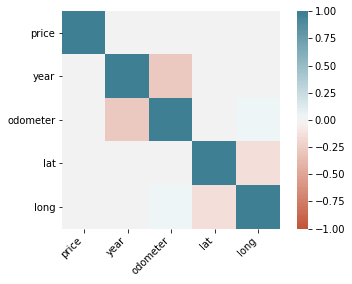

In [5]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

dataset = raw_data.drop(['description', 'id', 'url', 'vin', 'region_url', 'image_url', 'county'], axis = 1)
cont = dataset.columns[dataset.dtypes != object]
# df = df[cont]

corr = dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [6]:
cont = X.columns[X.dtypes != object]
cont

Index(['year', 'odometer', 'lat', 'long'], dtype='object')

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'long'),
 Text(0.5, 1.0, 'Freq Dist of long feature')]

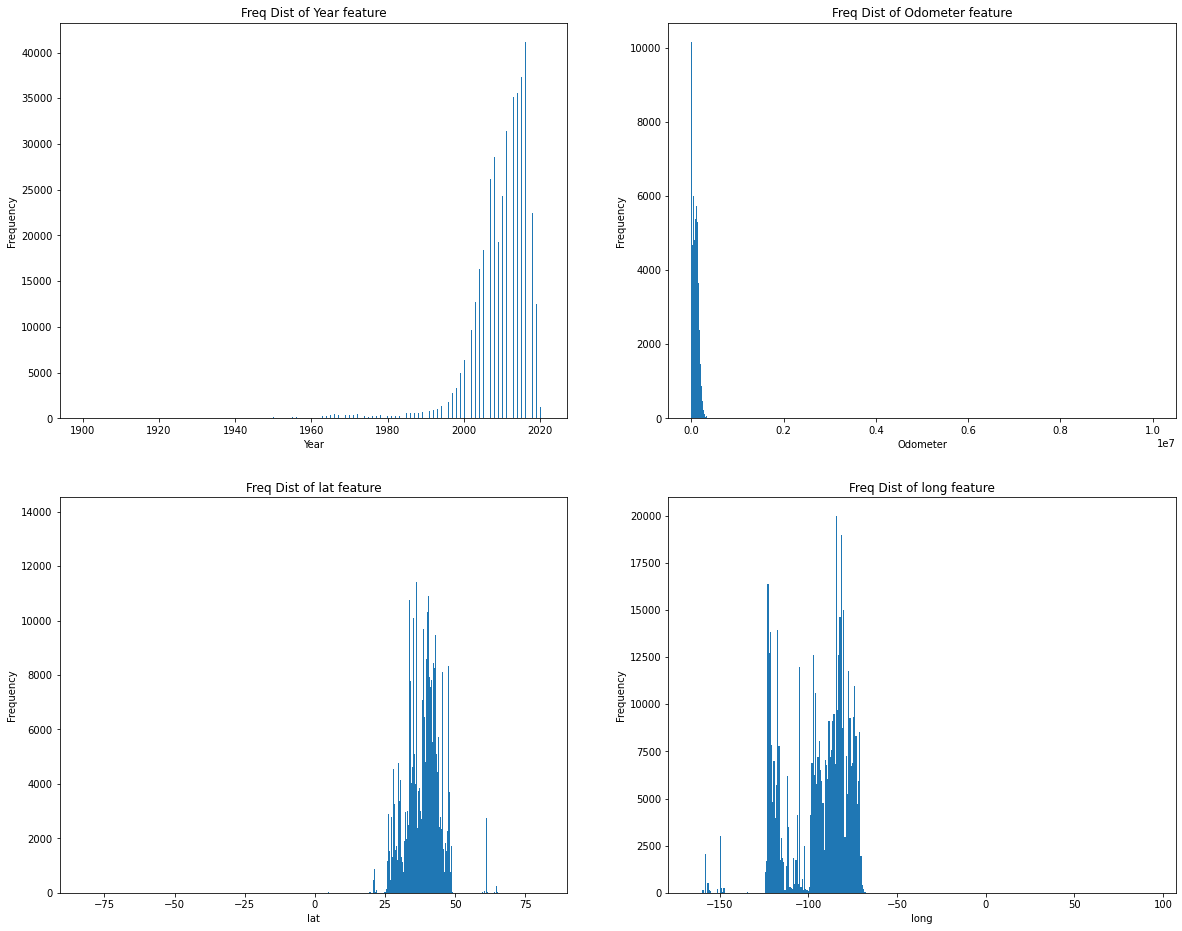

In [0]:
# Histograms


import matplotlib.pyplot as plt
df = dataset
cont = X.columns[X.dtypes != object]
fig,axes=plt.subplots(2,2,figsize=(20,16))
#Continuos Variable 1
axes[0,0].hist(df[cont[0]].dropna(),bins='auto')
axes[0,0].set(title='Freq Dist of Year feature',ylabel='Frequency',xlabel='Year')

#Continuos Variable 2
axes[0,1].hist(df[cont[1]].dropna(),bins='auto')
axes[0,1].set(title='Freq Dist of Odometer feature',ylabel='Frequency',xlabel='Odometer')

# #Continuos Variable 3
axes[1,0].hist(df[cont[2]].dropna(),bins='auto')
axes[1,0].set(title='Freq Dist of lat feature',ylabel='Frequency',xlabel='lat')

# #Continuos Variable 4
axes[1,1].hist(df[cont[3]].dropna(),bins='auto')
axes[1,1].set(title='Freq Dist of long feature',ylabel='Frequency',xlabel='long')

## Task 2 - PREPROCESSING AND BASELINE MODEL


Some entries have price equal to 0 which means they were listed on craigslist with a price of 0. It was also seen that this was the case eventhough their condition is listed as 'excellent'.Eventhough this may infact be true, for the purpose of this assignment, we are deleting all rows that have price 0.

In [7]:
raw_data.drop(raw_data[raw_data['price'] == 0 ].index , inplace=True)
# Separating X_raw and y_raw
raw_data = raw_data[raw_data.price != 0]
X_raw = raw_data.drop(['description', 'id', 'url', 'vin', 'region_url', 'image_url', 'county', 'price'], axis = 1)
y_raw = raw_data['price']

#### Baseline Model

Building a baseline model first by dropping all columns that have missing values.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw)
nan_columns = X_raw.columns[X_raw.isnull().any()]
X_drop_columns = X_train.drop(nan_columns, axis = 1)
categorical = X_drop_columns.columns[X_drop_columns.dtypes == object]

preprocess = make_column_transformer((TargetEncoder(), ['region']), (OneHotEncoder(handle_unknown = 'ignore'), categorical.drop(['region'])))
model_lr = make_pipeline(preprocess, LinearRegression())
scores_lr = cross_val_score(model_lr, X_drop_columns, y_train)

np.mean(scores_lr)

-0.04492744607149093

Negative R^2 value implies that the fit is worse than just fitting a horizontal line. Therefore, this baseline model (that contains only 'region' as its X feature and has deleted all other features) gives very poor results.

#### Exploring Patterns of missing data 

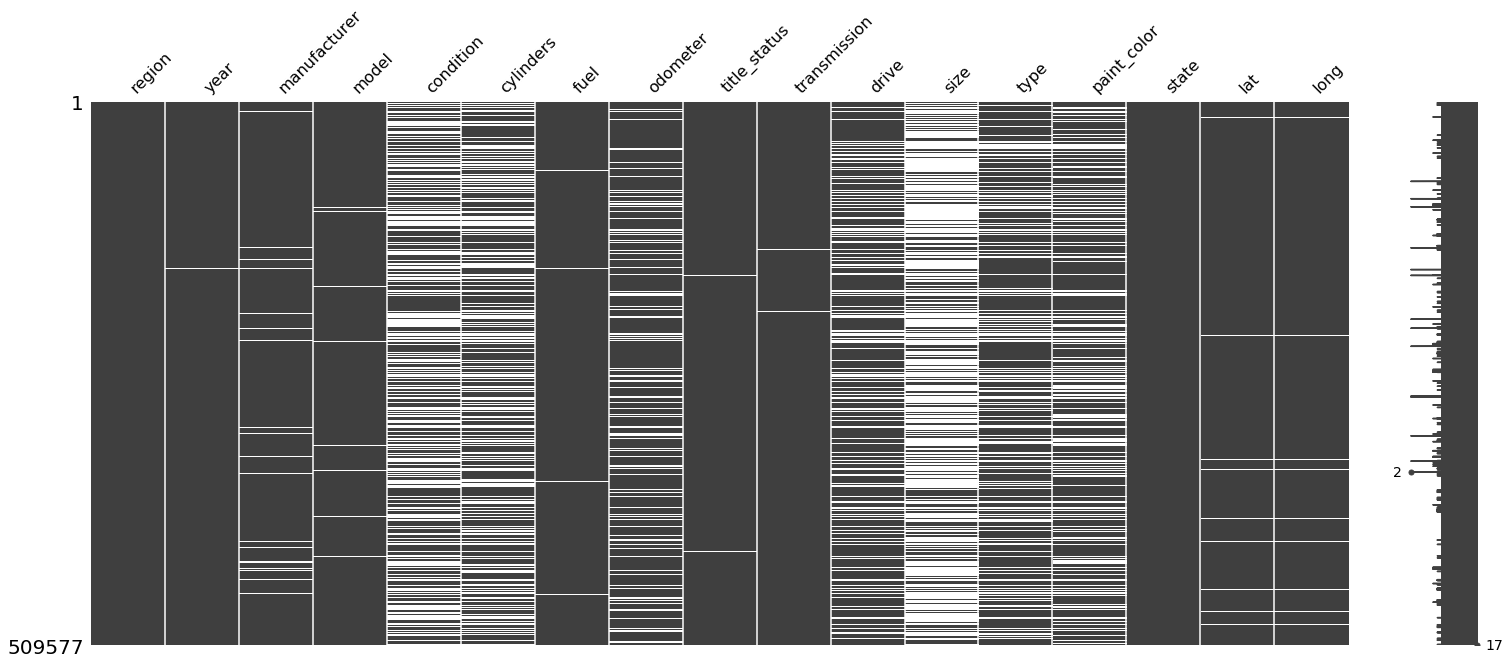

In [9]:
import missingno as msno 
msno.matrix(X) 

The msno.matrix nullity matrix shown above is a data-dense display that visualizes patterns in data completion. Nullity is defined as - whether a particular variable is filled in or not. The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

This data in particular seems to have no missing values in only three columns. There are no peculiar pattern observable, the data seems to be missing at random in a preliminary observation. If we observe the sparkline, the minimum number of non-missing values in a row is 2 and not 3.

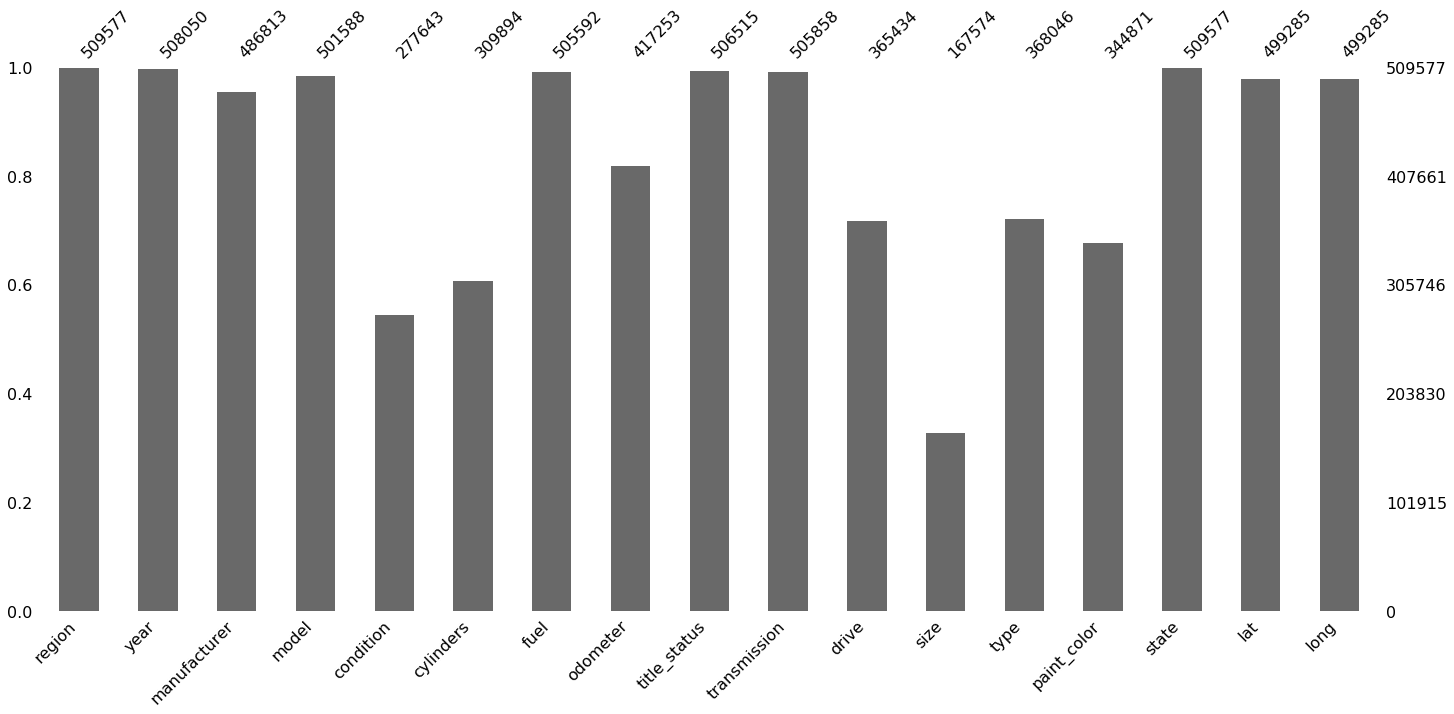

In [10]:
# Visualize the number of missing 
# values as a bar chart 
msno.bar(X) 

**msno.bar** is a simple visualization of nullity by column. Bar provides the same information as matrix, but in a simpler format.

Now, as you can see on the scale to the right, the maximum number of rows is 465998. From the bars, it is evident that only two columns are with out any missing values. However, this graph does not give information about the maximum and minimum nullity in the dataset. 

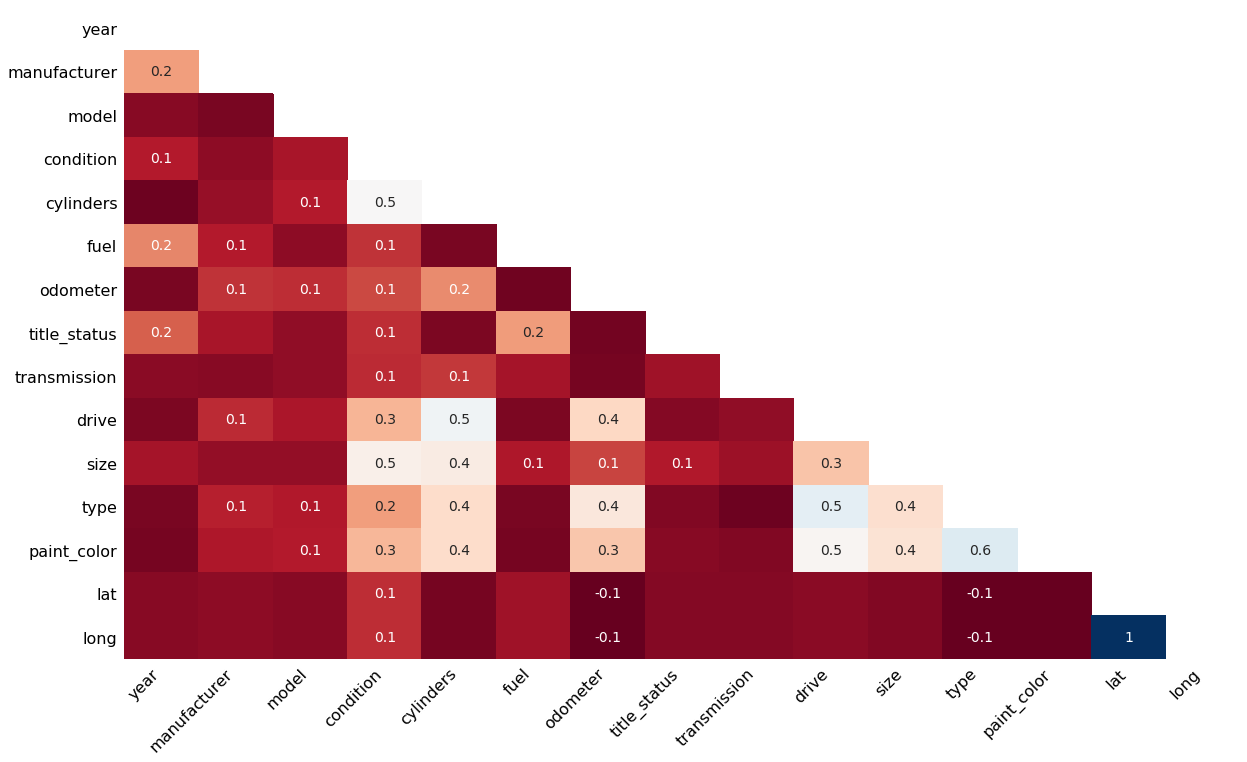

In [11]:
# Visualize the correlation between the number of 
# missing values in different columns as a heatmap 
msno.heatmap(X) 

The **missingno** correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.

Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does). From the above heatmap we see that most of the features have a correlation of less than 0.5. Only 5 combinations of features have a correlation of 0.5. One combination has a correlation of 0.6 and one combination of latitude and longitude have correlation of 1.

Variables that are always full or always empty have no meaningful correlation, and so are silently removed from the visualization—in this case for instance the *region* column, which is completely filled, is not included.


Therefore, from our exploration of patterns in missing data, we found no strong evidence to modify the dataset or its features.

## TASK 3 - FEATURE ENGINEERING

Performing more in-depth preprocessing and data cleaning.

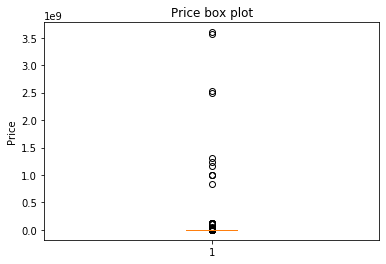

In [12]:
# Target variable 
import matplotlib.pyplot as plt
plt.boxplot(y_raw)
plt.title("Price box plot")
plt.ylabel("Price")
plt.show()

We can remove the outliers of price column (all those above upper quartile + 1.5*inter quartile range) since there are not enough data points in that range of target variable (price) that can help train a model well.

Price - upper whishker =  39875

Here is the boxplot of price after the outliers are removed.


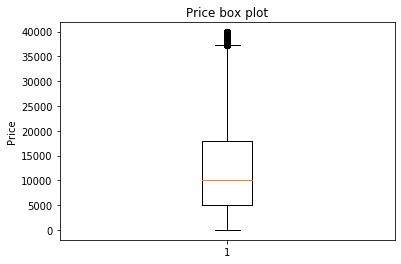

In [13]:
stats = raw_data['price'].describe()

upper_quartile = stats[6]
lower_quartile = stats[4]

iqr = upper_quartile - lower_quartile
upper_whisker = raw_data['price'][raw_data.price<=upper_quartile+1.5*iqr].max()
y_raw_wo_outliers = raw_data['price'][raw_data.price<=upper_quartile+1.5*iqr]
# upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
print("Price - upper whishker = ", upper_whisker)

print("\nHere is the boxplot of price after the outliers are removed.")
import matplotlib.pyplot as plt
plt.boxplot(y_raw_wo_outliers)
plt.title("Price box plot")
plt.ylabel("Price")
plt.show()

dataset_y_updated = dataset[dataset.price<=upper_quartile+1.5*iqr]
# dataset_y_updated.head()
# dataset_y_updated.shape

Next, we check for outliers in the features.

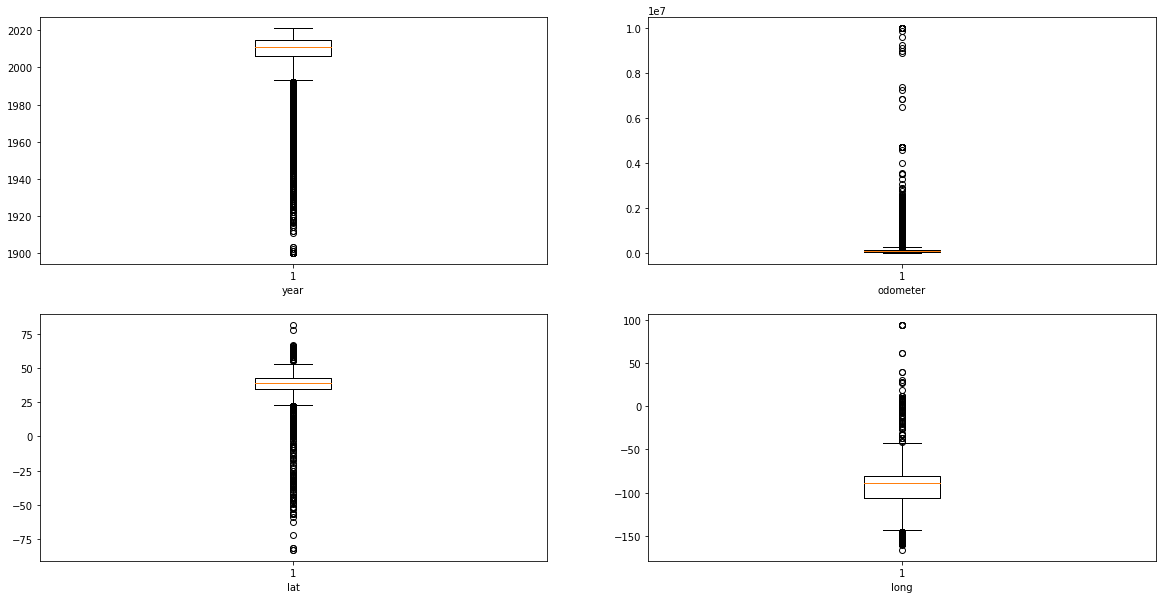

In [14]:
### Features Analysis using Exploration
#1. Continuous features -- histogram?
cont = X_raw.columns[X_raw.dtypes != object]
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(20, 10))

counter = 0
for i in range(2):
    for j in range(2):

        ax1 = axes[i][j]

        # Plot when we have data
        if counter < len(cont):
            ax1.boxplot(raw_data[cont[counter]].dropna())
            ax1.set_xlabel(cont[counter])
            
        else:
            ax1.set_axis_off()
            
        counter += 1

plt.show()

We observe many outliers in the boxplot of 'years' (below the lower whisker). Since car prices will depend more on the current or recent market condition, it is logical to remove the outliers that appear below the lower whisker. 

Year feature - lower whishker = 1993.0

Here is the boxplot of year after the outliers below lower whishker are removed.


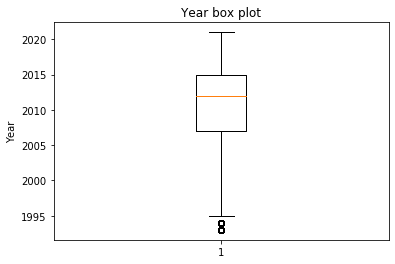

In [15]:
# checking year feature
stats = raw_data['year'].describe()

upper_quartile = stats[6]
lower_quartile = stats[4]

iqr = upper_quartile - lower_quartile
lower_whisker = raw_data['year'][raw_data.year>=lower_quartile-1.5*iqr].min()
print("Year feature - lower whishker =", lower_whisker)

dataset_year_updated = dataset_y_updated[dataset_y_updated.year>=lower_quartile-1.5*iqr]
print("\nHere is the boxplot of year after the outliers below lower whishker are removed.")
import matplotlib.pyplot as plt
plt.boxplot(dataset_year_updated['year'])
plt.title("Year box plot")
plt.ylabel("Year")
plt.show()

We find that the lower whisker corresponds to the year 1993. Hence, the updated dataset contains data points corresponding to years after 1993.

The dataset contains years after 2020 as well which is an impossible data point to have. Hence we filter out these as well.

In [16]:
dataset_year_updated = dataset_year_updated[dataset_year_updated.year<=2020]

Odometer feature - upper whishker = 274000

Here is the boxplot of odometer after the outliers above upper whishker are removed.


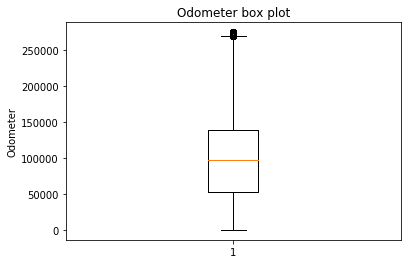

In [17]:
# Odometer
# checking year feature
stats = raw_data['odometer'].describe()

upper_quartile = stats[6]
lower_quartile = stats[4]

iqr = upper_quartile - lower_quartile
upper_whisker = raw_data['price'][raw_data.price<=upper_quartile+1.5*iqr].max()
print("Odometer feature - upper whishker =", upper_whisker)

dataset_odo_updated = dataset_year_updated[dataset_year_updated.odometer<=upper_quartile+1.5*iqr]
print("\nHere is the boxplot of odometer after the outliers above upper whishker are removed.")
import matplotlib.pyplot as plt
plt.boxplot(dataset_odo_updated['odometer'])
plt.title("Odometer box plot")
plt.ylabel("Odometer")
plt.show()

We do not remove outlier as visible in the boxplot of latitude and longitude values since it does not makes sense to remove values representing locations and not numeric features that help predict the target variable.

In [18]:
#Updating X and y after preprocessing

X = dataset_odo_updated.drop('price', axis=1)
y = dataset_odo_updated['price']

#### Imputation

Now, we discuss imputing the missing values. Columns of categorical data type can be imputed with the most frequent value in column. Columns of continuous type can be imputed with mean of column. <b> It is important to note that all preprocessing including imputation should be done after train test split to avoid data leakage.</b> One way is to perform imputation in the (sklearn) pipeline as mentioned above after splitting the data into train and test sets. Since it was taking a lot of time when the preprocessing was done in the pipe each time, we decided to split the train and test data, impute the train and test data sets and then use these for each model we wish to fit.

In [19]:
X_train_main, X_test_main, y_train_main, y_test_main = train_test_split(X, y)
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X], index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

X_train_main = DataFrameImputer().fit_transform(X_train_main)
X_test_main = DataFrameImputer().transform(X_test_main)

Running the Linear Regression model again on imputed data.

In [20]:

categorical = X_train_main.columns[X_train_main.dtypes == object]
# continuous = X_train.columns[X_train.dtypes != object]

preprocess = make_column_transformer((TargetEncoder(), ['region', 'model']),(OneHotEncoder(handle_unknown = 'ignore'), categorical.drop(['region', 'model'])), remainder = "passthrough")
model_lr = make_pipeline(preprocess, LinearRegression())
scores_lr = cross_val_score(model_lr, X_train_main, y_train_main)

np.mean(scores_lr)

0.5323353842981273

The accuracy seems to have improved after imputation. Therefore, we can say that our data imputation (replacing categorical variables with most frequent values, and mean imputation of continuous variables) and data cleaning result in better accuracy.

Since the number of data points is huge, we subsample data in a stratified manner so that the categories are preserved in the subsampled data.

In [21]:
#resampling
from sklearn.utils import resample
X_train, y_train = resample(X_train_main , y_train_main, random_state=0, n_samples=int(X_train_main.shape[0]/70))
X_test, y_test = resample(X_test_main , y_test_main, random_state=0, n_samples=int(X_test_main.shape[0]/70))
print(X_train.shape)
print(y_train.shape)

(4208, 17)
(4208,)


## SAMPLE 1 (SIZE divided by 70)

Checking whether adding interactions between the features helps.

Encoding the categorical variables region and model using target encoding since they have large number of categories. Encoding them through one hot encoding will result in a extremely huge dataset.

In [22]:
#Input matrix for 2 degree

from sklearn.preprocessing import PolynomialFeatures

# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)
categorical = X_train.columns[X_train.dtypes == object]


preprocess = make_column_transformer((TargetEncoder(), ['region', 'model']),(OneHotEncoder(handle_unknown = 'ignore'), categorical.drop(['region', 'model'])), remainder = "passthrough")
model_lr = make_pipeline(preprocess, PolynomialFeatures(degree =2), LinearRegression())
scores_lr = cross_val_score(model_lr, X_train, y_train)

np.mean(scores_lr)

0.44684096998210093

We were unable to fit polynomial features of degree 3 (due to memory limitation error) and on camparing degree 1 and 2, we find that features with degree 1 fit better on linear regression. The best accuracy is 0.53.

## Task 4 - ANY MODEL

We chose to explore four different models. 

In [23]:
#helper plot function for upcoming plotting

import matplotlib.pyplot as plt
def plot_graph(X, y, title, xlabel, ylabel, need_log_x, lab):
    plt.plot(X, y, label=lab)
    if (need_log_x == 1):
        plt.xscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    if lab:
        plt.legend()
        
preprocess_scaler = make_column_transformer((TargetEncoder(), ['region', 'model']),(OneHotEncoder(handle_unknown = 'ignore'), categorical_ohe),
(StandardScaler(), ~categorical_ohe), remainder = "passthrough")
preprocess = make_column_transformer((TargetEncoder(), ['region', 'model']),(OneHotEncoder(handle_unknown = 'ignore'), categorical.drop(['region', 'model'])), remainder = "passthrough")

In [24]:
# GridSearch on Linear SVR (Linear)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.svm import LinearSVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

# categorical_ohe = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status',
#        'transmission', 'drive', 'size', 'type', 'paint_color','state']
categorical_ohe = X_train.dtypes == object

model_svr = make_pipeline(preprocess_scaler, LinearSVR())
param_grid = {'linearsvr__C':[0.0001,0.001,0.01,0.1,1]}
grid_svr = GridSearchCV(model_svr,param_grid = param_grid,return_train_score=True)
grid_svr.fit(X_train,y_train)
print("tuned hyperparameters :(best parameters) ",grid_svr.best_params_)
print("accuracy :",grid_svr.best_score_)

tuned hyperparameters :(best parameters)  {'linearsvr__C': 0.0001}
accuracy : 0.13022668728559347


Support Vector Regressor - best parameters: {'linearsvr__C': 0.0001}
Support Vector Regressor - best mean cross-validation score: 0.1302


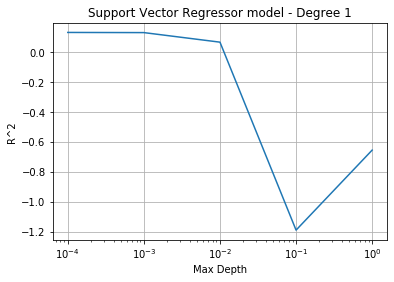

In [25]:
svr_vals = [d['linearsvr__C'] for d in grid_svr.cv_results_['params']]
# plot
plot_graph(svr_vals, grid_svr.cv_results_['mean_test_score'].tolist(), 'Support Vector Regressor model - Degree 1', 'Max Depth', 'R^2', 1, None)


print("Support Vector Regressor - best parameters: {}".format(grid_svr.best_params_))
print("Support Vector Regressor - best mean cross-validation score: {:.4f}".format(grid_svr.best_score_))

In [27]:
#Linear SVR (Quadratic) with the best C on previous grid search

model_svr2 = make_pipeline(preprocess_scaler, PolynomialFeatures(degree =2), LinearSVR(C = 0.001))
scores_svr2 = cross_val_score(model_svr2, X_train, y_train)

np.mean(scores_svr2)

-2.318351327749881

For Linear SVR, we find that features with degree 1 fit better. The best accuracy is 0.1302

Decision Tree Regressor - best parameters: {'decisiontreeregressor__max_depth': 5}
Decision Tree Regressor - best mean cross-validation score: 0.3241


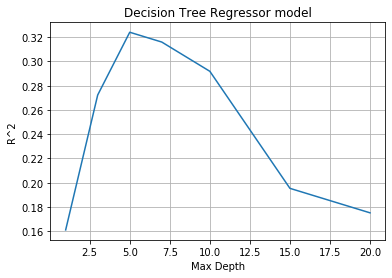

In [28]:
# GridSearch on Decision Tree (Linear features)

from sklearn.tree import DecisionTreeRegressor

model_dt = make_pipeline(preprocess_scaler, DecisionTreeRegressor())
param_grid = {'decisiontreeregressor__max_depth':[1, 3, 5, 7, 10, 15, 20]}
grid_dt = GridSearchCV(model_dt, param_grid = param_grid, return_train_score=True, cv = 5)
grid_dt.fit(X_train,y_train)

dt_vals = [d['decisiontreeregressor__max_depth'] for d in grid_dt.cv_results_['params']]
# plot
plot_graph(dt_vals, grid_dt.cv_results_['mean_test_score'].tolist(), 'Decision Tree Regressor model', 'Max Depth', 'R^2', 0, None)


print("Decision Tree Regressor - best parameters: {}".format(grid_dt.best_params_))
print("Decision Tree Regressor - best mean cross-validation score: {:.4f}".format(grid_dt.best_score_))

In [29]:
# GridSearch on Decision Tree (Quadratic features)

model_dt = make_pipeline(preprocess_scaler,PolynomialFeatures(degree = 2), DecisionTreeRegressor(max_depth = 5))
scores_dt = cross_val_score(model_dt, X_train, y_train)

np.mean(scores_dt)

0.35557297620801165

For Decision Tree, we find that features with degree 2 fit better. The best accuracy is 0.35. 

Random Forest Regressor - best parameters: {} {'randomforestregressor__max_depth': 25}
Random Forest Regressor - best mean cross-validation score 0.46612522107569204


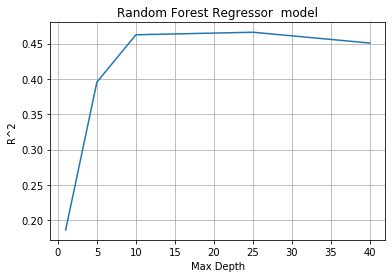

In [30]:
# GridSearch on Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor


model_rf = make_pipeline(preprocess, RandomForestRegressor(n_estimators = 10))
param_grid = {'randomforestregressor__max_depth':[1, 5, 10, 25, 40]}
grid_rf = GridSearchCV(model_rf, param_grid = param_grid, return_train_score=True, cv = 10)
grid_rf.fit(X_train,y_train)
 
rf_vals = [d['randomforestregressor__max_depth'] for d in grid_rf.cv_results_['params']]
# plot
plot_graph(rf_vals, grid_rf.cv_results_['mean_test_score'].tolist(), 'Random Forest Regressor  model', 'Max Depth', 'R^2', 0, None)


print("Random Forest Regressor - best parameters: {}",grid_rf.best_params_)
print("Random Forest Regressor - best mean cross-validation score",grid_rf.best_score_)


In [32]:
#Random Forest Regressor (Quadratic features)

model_rf = make_pipeline(preprocess, PolynomialFeatures(degree =2),RandomForestRegressor(n_estimators = 10, max_depth = 25))
scores_rf = cross_val_score(model_rf, X_train, y_train)

np.mean(scores_rf)

0.46308699562107625

For Random Forest Regressor, we find that features with degree 1 fit better. The best accuracy is 0.466.

Gradient Boosting Regressor - best parameters: {} {'gradientboostingregressor__max_depth': 7}
Gradient Boosting Regressor - best mean cross-validation score 0.5178087838542818


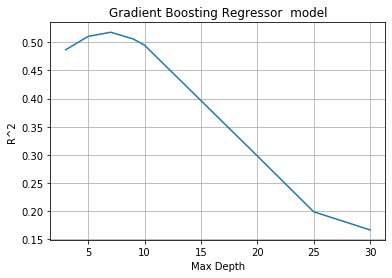

In [34]:
#GridSearch on Gradient Boosting Regressor

from sklearn.ensemble import GradientBoostingRegressor

model_gbr = make_pipeline(preprocess, GradientBoostingRegressor())
param_grid = {'gradientboostingregressor__max_depth':[3,5,7,9,10,20,25,30]}
grid_gbr = GridSearchCV(model_gbr,param_grid = param_grid,return_train_score=True)
grid_gbr.fit(X_train,y_train)

gbr_vals = [d['gradientboostingregressor__max_depth'] for d in grid_gbr.cv_results_['params']]
# plot
plot_graph(gbr_vals, grid_gbr.cv_results_['mean_test_score'].tolist(), 'Gradient Boosting Regressor  model', 'Max Depth', 'R^2', 0, None)

print("Gradient Boosting Regressor - best parameters: {}", grid_gbr.best_params_)
print("Gradient Boosting Regressor - best mean cross-validation score", grid_gbr.best_score_)

In [35]:
#Gradient Boosting Regressor(Quadratic features)

model_gbr = make_pipeline(preprocess,PolynomialFeatures(degree =2), GradientBoostingRegressor(max_depth = 7))
scores_gbr = cross_val_score(model_gbr, X_train, y_train)

np.mean(scores_gbr)

0.5166476754739355

For Gradient Boosting Regressor, we find that features with degree 1 fit better. The best accuracy is 0.518.

/Users/swarnabharathimantena/opt/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


XGB Regressor - best parameters: {} {'xgbregressor__max_depth': 10}
XGBt Regressor - best mean cross-validation score 0.5428725093770359


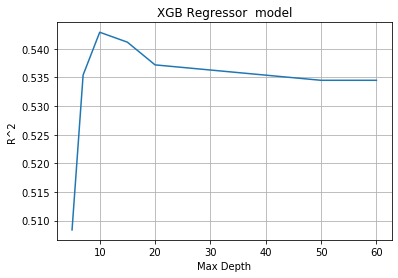

In [36]:
#GridSearch on XGBoost Regressor (linear features)
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 50, 
                         alpha = 10, n_estimators = 50)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# x_selected = pd.DataFrame(x_selected)
# categorical_ohe = X_train.dtypes == object

model_xg = make_pipeline(preprocess, xg_reg)
param_grid = {'xgbregressor__max_depth':[5, 7, 10, 15, 20, 50, 60]}
grid_xg = GridSearchCV(model_xg, param_grid = param_grid, return_train_score=True, cv = 5)
grid_xg.fit(X_train, y_train)

xg_vals = [d['xgbregressor__max_depth'] for d in grid_xg.cv_results_['params']]
# plot
plot_graph(xg_vals, grid_xg.cv_results_['mean_test_score'].tolist(), 'XGB Regressor  model', 'Max Depth', 'R^2', 0, None)


print("XGB Regressor - best parameters: {}",grid_xg.best_params_)
print("XGBt Regressor - best mean cross-validation score",grid_xg.best_score_)

In [37]:
#XGBoost Regressor(Quadratic features)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, 
                         alpha = 10, n_estimators = 50)
model_xg = make_pipeline(preprocess, PolynomialFeatures(degree =2), xg_reg)
scores_xg = cross_val_score(model_xg, X_train, y_train)

np.mean(scores_xg)

0.5197634953236097

For XGB Regressor, we find that features with degree 1 fit better. The best accuracy is 0.543.

## SAMPLE 2 (SIZE divided by 10)

In [38]:
#resampling
from sklearn.utils import resample
X_train, y_train = resample(X_train_main , y_train_main, random_state=0, n_samples=int(X_train_main.shape[0]/10))
X_test, y_test = resample(X_test_main , y_test_main, random_state=0, n_samples=int(X_test_main.shape[0]/10))
print(X_train.shape)
print(y_train.shape)

(29457, 17)
(29457,)


Checking whether adding interactions between the features helps.

Encoding the categorical variables region and model using target encoding since they have large number of categories. Encoding them through one hot encoding will result in a extremely huge dataset.

In [39]:
#Linear Regression

from sklearn.preprocessing import PolynomialFeatures

# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)
categorical_ohe = X_train.dtypes == object


preprocess = make_column_transformer((TargetEncoder(), ['region', 'model']),(OneHotEncoder(handle_unknown = 'ignore'), categorical.drop(['region', 'model'])), remainder = "passthrough")
model_lr = make_pipeline(preprocess,LinearRegression())
scores_lr = cross_val_score(model_lr, X_train, y_train)

np.mean(scores_lr)

0.491339203000763

We got better accuracy on sample 1 for linear regression.

In [40]:
##  Linear SVR 

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

model_svr = make_pipeline(preprocess_scaler, LinearSVR(C = 0.001))
scores_svr = cross_val_score(model_svr, X_train, y_train)

np.mean(scores_svr)

0.2211740697450411

We got better accuracy on sample 2 for linear SVR.

In [41]:
#Decision Tree 

model_dt = make_pipeline(preprocess_scaler, PolynomialFeatures(degree = 2), DecisionTreeRegressor(max_depth = 5))
scores_dt = cross_val_score(model_dt, X_train, y_train)

np.mean(scores_dt)

0.4482559518568413

For Decision Tree, we got better accuracy for sample 2.

In [42]:
#Random Forest Regressor

model_rf = make_pipeline(preprocess, RandomForestRegressor(n_estimators = 10, max_depth = 25))
scores_rf = cross_val_score(model_rf, X_train, y_train)

np.mean(scores_rf)

0.6068819633125783

In [43]:
#Gradient Boosting Regressor

model_gbr = make_pipeline(preprocess, GradientBoostingRegressor(max_depth = 7))
scores_gbr = cross_val_score(model_gbr, X_train, y_train)

np.mean(scores_gbr)

0.6411367909807064

In [44]:
#XGBoost Regressor

xg_reg = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, 
                         alpha = 10, n_estimators = 50)
model_xg = make_pipeline(preprocess, xg_reg)
scores_xg = cross_val_score(model_xg, X_train, y_train)

np.mean(scores_xg)

0.6363408550187576

## SAMPLE 3 (SIZE divided by 2)

In [45]:
#resampling
from sklearn.utils import resample
X_train, y_train = resample(X_train_main , y_train_main, random_state=0, n_samples=int(X_train_main.shape[0]/2))
X_test, y_test = resample(X_test_main , y_test_main, random_state=0, n_samples=int(X_test_main.shape[0]/2))
print(X_train.shape)
print(y_train.shape)

(147288, 17)
(147288,)


Checking whether adding interactions between the features helps.

Encoding the categorical variables region and model using target encoding since they have large number of categories. Encoding them through one hot encoding will result in a extremely huge dataset.

In [46]:
#Linear Regression

from sklearn.preprocessing import PolynomialFeatures

# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)
categorical_ohe = X_train.dtypes == object

preprocess = make_column_transformer((TargetEncoder(), ['region', 'model']),(OneHotEncoder(handle_unknown = 'ignore'), categorical.drop(['region', 'model'])), remainder = "passthrough")
model_lr = make_pipeline(preprocess,LinearRegression())
scores_lr = cross_val_score(model_lr, X_train, y_train)

np.mean(scores_lr)

0.5291913197301451

In [47]:
##  Linear SVR 
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

model_svr = make_pipeline(preprocess_scaler, LinearSVR(C = 0.001))
scores_svr = cross_val_score(model_svr, X_train, y_train)

np.mean(scores_svr)

0.32243507989013026

In [49]:
#Decision Tree 

model_dt = make_pipeline(preprocess_scaler, DecisionTreeRegressor(max_depth = 5))
scores_dt = cross_val_score(model_dt, X_train, y_train)

np.mean(scores_dt)

0.4720829884206285

In [50]:
#Random Forest Regressor

model_rf = make_pipeline(preprocess, RandomForestRegressor(n_estimators = 10, max_depth = 25))
scores_rf = cross_val_score(model_rf, X_train, y_train)

np.mean(scores_rf)

0.782784480924709

In [51]:
#Gradient Boosting Regressor

model_gbr = make_pipeline(preprocess, GradientBoostingRegressor(max_depth = 7))
scores_gbr = cross_val_score(model_gbr, X_train, y_train)

np.mean(scores_gbr)

0.7024767161261292

In [53]:
#XGBoost Regressor

xg_reg = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 50, 
                         alpha = 10, n_estimators = 50)
model_xg = make_pipeline(preprocess, xg_reg)
scores_xg = cross_val_score(model_xg, X_train, y_train)

np.mean(scores_xg)

0.8449033481816439

Therefore the results from all models run before can be summarized as in the following table.
<img src="table.png" width="800" height="200">

We observe the highest accuracy of 0.84 from XGBoost Regressor with max_depth = 50 as its best hyperparameter over 50% subsampled data.

In [68]:
# Test set score
xg_reg = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 50, 
                         alpha = 10, n_estimators = 50)
model_xg = make_pipeline(preprocess, xg_reg)
model_xg.fit(X_train, y_train)
score = model_xg.score(X_test, y_test)
score

0.7855554315110209

Accuracy obtained by our best model on the test set is **0.78**.

## Task 5 - FEATURE SELECTIONS

#### Model based (single fit)

In [55]:
cat = X_train.columns[X_train.dtypes == object] # X_train corresponds to sample 3 - 50% data
cat

Index(['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object')

In [56]:
cont = X_train.columns[X_train.dtypes != object]
cont

Index(['year', 'odometer', 'lat', 'long'], dtype='object')

In [57]:
cat.drop(['model', 'region'])

Index(['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status',
       'transmission', 'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

The features are listed from most important to least important below:

In [58]:
import operator

# cat = X_resampled.columns[X_resampled.dtypes == object]


model_xg.fit(X_train, y_train)
coefs = model_xg.named_steps['xgbregressor'].feature_importances_
features = model_xg.named_steps['columntransformer'].transformers_[1][1].get_feature_names(cat.drop(['region', 'model']))
features_all = ['region', 'model'] + list(features) + ['year', 'odometer', 'lat', 'long']
feature_vals = dict(zip(features_all, coefs))
feature_vals_sorted = dict(sorted(feature_vals.items(), key=lambda x: x[1], reverse=True))
feature_vals_sorted

{'fuel_diesel': 0.13760047,
 'type_pickup': 0.047176696,
 'drive_fwd': 0.036753,
 'transmission_other': 0.03273031,
 'year': 0.029176062,
 'condition_fair': 0.02907298,
 'state_wv': 0.019839594,
 'drive_4wd': 0.019449202,
 'manufacturer_tesla': 0.019058894,
 'cylinders_4 cylinders': 0.017921641,
 'manufacturer_alfa-romeo': 0.015820652,
 'cylinders_8 cylinders': 0.014415969,
 'cylinders_12 cylinders': 0.013231624,
 'fuel_gas': 0.013034806,
 'manufacturer_ram': 0.01158773,
 'cylinders_10 cylinders': 0.010081018,
 'fuel_other': 0.009914202,
 'type_bus': 0.009838208,
 'condition_good': 0.009685144,
 'state_ak': 0.009586005,
 'model': 0.0094891125,
 'drive_rwd': 0.008884848,
 'state_sc': 0.008874365,
 'cylinders_6 cylinders': 0.008481632,
 'title_status_lien': 0.008073865,
 'state_mt': 0.008033966,
 'manufacturer_ferrari': 0.007974619,
 'type_other': 0.0076051615,
 'manufacturer_rover': 0.00740382,
 'state_hi': 0.007368849,
 'state_la': 0.00731532,
 'state_nc': 0.0068675154,
 'state_ca': 0.

In [59]:
import itertools
import collections

l = len(feature_vals_sorted)
feature_vals_selected = collections.OrderedDict(feature_vals_sorted)
feature_vals_selected = itertools.islice(feature_vals_selected.items(), 0, int(l/2)) #50%
feature_vals_selected = dict(feature_vals_selected)
# for key, value in feature_vals_selected:
#     print (key, value)

We take top 50% features as most relevant features and last 50% as least important features. 


Now, to remove these features, we will have to create the dataframe of input train X that is obtained after pipeline and column transformer are called over it. To do this, we need to target encode, one hot encode the corresponding columns, and add the continuous columns by ourselves. Next, we remove 50% features that have least importance and train the model on the modified feature set input. So we built the necessary X_train and X_test for our model from scratch without using pipeline.

In [60]:
#Transformed Class to target encode columns
#Taken from Category Encoders manual:https://contrib.scikit-learn.org/categorical-encoding/_modules/category_encoders/target_encoder.html#TargetEncoder

class TargetEncoder():
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [61]:
#Selecting corresponding columns #X_train
X_train_columns_to_target_encode = X_train[['model','region']]
X_train_columns_to_ohe = X_train[['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status',
       'transmission', 'drive', 'size', 'type', 'paint_color','state']]

In [62]:
#Applying the target encoding

te = TargetEncoder()
X_train_target_encoded = te.fit_transform(X_train_columns_to_target_encode, y_train)
X_train_target_encoded.sample(10)

,model,region
258078,15079.349325,14322.563492
127831,10885.833333,12360.663252
449296,4040.289157,7786.971014
71849,13637.865248,11481.856723
472295,7777.400000,16785.839246
260745,9325.039877,12401.729114
11323,7162.055790,9607.571709
232586,12730.195833,12494.533408
198769,16341.362934,13633.939799
450260,38416.666667,11053.766744


In [63]:
#Applying the one hot encoding
X_train_ohe = pd.get_dummies(X_train_columns_to_ohe)

#Placing the DataFrames side by side
X_train_built_from_scratch = pd.concat([X_train_target_encoded, X_train_ohe], axis=1)
X_train_built_from_scratch = pd.concat([X_train_built_from_scratch, X_train[['year', 'odometer', 'lat', 'long']]], axis=1)

In [64]:
# X_test preprocessing - creating corresponding X_test
#Selecting corresponding columns #X_test
X_test_columns_to_target_encode = X_test[['model','region']]
X_test_columns_to_ohe = X_test[['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status',
       'transmission', 'drive', 'size', 'type', 'paint_color','state']]

te = TargetEncoder()
X_test_target_encoded = te.fit_transform(X_test_columns_to_target_encode, y_test)
# X_test_target_encoded.sample(10)


#Applying the one hot encoding
X_test_ohe = pd.get_dummies(X_test_columns_to_ohe)

#Placing the DataFrames side by side
X_test_built_from_scratch = pd.concat([X_test_target_encoded, X_test_ohe, X_test[['year', 'odometer', 'lat', 'long']]], axis=1)

In [65]:
#Running XGBoost Regressor on the new features

filtered_X_train = X_train_built_from_scratch.copy()
selected_features = list(feature_vals_selected.keys())
for item in filtered_X_train.columns:
    if item not in selected_features:
        filtered_X_train = filtered_X_train.drop([item], axis = 1)
        

filtered_X_test = X_test_built_from_scratch.copy()
selected_features = list(feature_vals_selected.keys())
for item in filtered_X_test.columns:
    if item not in selected_features or item not in filtered_X_train.columns:
        filtered_X_test = filtered_X_test.drop([item], axis = 1)
        
for item in filtered_X_train.columns:
    if item not in filtered_X_test.columns:
        filtered_X_test[item] = 0
        
filtered_X_test = filtered_X_test[filtered_X_train.columns]


xg_reg_selected = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 50, 
                         alpha = 10, n_estimators = 50)
scores_xg_reg_selected = cross_val_score(xg_reg_selected, filtered_X_train, y_train)

np.mean(scores_xg_reg_selected)

0.8634686239878752

The score of XGBoost Regressor model on original data was 84%. After removing the least important 50% of the features, we see that the accuracy has slightly increased. Next, we can try removing the least important 10% of the featrues and see the results as follows:

In [66]:
# 90%

l = len(feature_vals_sorted)
feature_vals_selected = collections.OrderedDict(feature_vals_sorted)
feature_vals_selected = itertools.islice(feature_vals_selected.items(), 0, int(l*0.9))
feature_vals_selected = dict(feature_vals_selected)


filtered_X_train = X_train_built_from_scratch.copy()
selected_features = list(feature_vals_selected.keys())
for item in filtered_X_train.columns:
    if item not in selected_features:
        filtered_X_train = filtered_X_train.drop([item], axis = 1)
        

filtered_X_test = X_test_built_from_scratch.copy()
selected_features = list(feature_vals_selected.keys())
for item in filtered_X_test.columns:
    if item not in selected_features or item not in filtered_X_train.columns:
        filtered_X_test = filtered_X_test.drop([item], axis = 1)
        
        
for item in filtered_X_train.columns:
    if item not in filtered_X_test.columns:
        filtered_X_test[item] = 0
        
        
filtered_X_test = filtered_X_test[filtered_X_train.columns]

xg_reg_selected = xgb.XGBRegressor(objective='reg:squarederror',colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 50, 
                         alpha = 10, n_estimators = 50)
scores_xg_reg_selected = cross_val_score(xg_reg_selected, filtered_X_train, y_train)

np.mean(scores_xg_reg_selected)

0.8555249937539002

So we observe that the accuracy has slightly decreased when when compared to 50% feature reduction, but the overall accuracy has increased by 1%. 
Therefore, the feature selection done was successful.

## Task 6 - AN EXPLAINABLE MODEL

We decided to choose top 20% features from our data. On fitting the data on a Decision tree with depth 4, we find it gives a comparable accuracy to our best model which is xgboost with depth 10. Also, on fitting the data on a Linear Regression model, we find it also gives a comparable accuracy to our best model.
- Accuracy of XGB Regressor (best model): 0.59
- Accuracy of Decision Tree with depth 4 : 0.53
- Accuracy of Linear Regression: 0.53

In [78]:
l = len(feature_vals_sorted)
feature_vals_selected = collections.OrderedDict(feature_vals_sorted)
feature_vals_selected = itertools.islice(feature_vals_selected.items(), 0, int(l*0.2))
feature_vals_selected = dict(feature_vals_selected)
features_20percent = list(filtered_X_test.columns)
# features_20percent

filtered_X_train = X_train_built_from_scratch.copy()
selected_features = list(feature_vals_selected.keys())
for item in filtered_X_train.columns:
    if item not in selected_features:
        filtered_X_train = filtered_X_train.drop([item], axis = 1)
        

filtered_X_test = X_test_built_from_scratch.copy()
selected_features = list(feature_vals_selected.keys())
for item in filtered_X_test.columns:
    if item not in selected_features or item not in filtered_X_train.columns:
        filtered_X_test = filtered_X_test.drop([item], axis = 1)
        
        
for item in filtered_X_train.columns:
    if item not in filtered_X_test.columns:
        filtered_X_test[item] = 0
        
        
filtered_X_test = filtered_X_test[filtered_X_train.columns]

In [97]:
# top 20% features - max depth 10
import xgboost as xgb
# from sklearn.model_selection import GridSearchCV

xg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, 
                         alpha = 10, n_estimators = 50)
xg = xg.fit(filtered_X_train, y_train)
score = xg.score(filtered_X_test, y_test)
print(score)

0.5937017065763495


In [93]:
# 20% - max depth 4
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth = 4)
dt = dt.fit(filtered_X_train, y_train)
score = dt.score(filtered_X_test, y_test)
print(score)

0.5282802383342708


In [96]:
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz as gv

dot_data = tree.export_graphviz(dt, out_file=None, 
                      feature_names=features_20percent,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = gv.Source(dot_data)  
graph.render('dt_graph', view=True)

'dt_graph.pdf'

<img src="dt_graph.png" >

The decision tree chose model,and year as its most important features to build a tree with depth 4. The root node is split based on the feature 'model' - whether it is less than or greater than the value 13368 (this is a target encoded feature) - it is the average of all values found in its category. Hence, if the average value of a particular category is less than 13368, the tree directs towards its left child (true condition), else it directs towards the right child. Similarly, other features are conditioned and analyzed in different nodes of the tree till it reaches a leaf node that contains the regression output (predicted price of the car).

In [84]:
# 20% 
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
scores_lr = cross_val_score(lr, filtered_X_train, y_train)

np.mean(scores_lr)

0.5357708180601817

In [86]:
lr = LinearRegression()
lr.fit(filtered_X_train, y_train)


coefs = list(lr.coef_)
linear_model_coefs = pd.DataFrame(list(zip(features_20percent, coefs)), columns =['features', 'coefficients']) 
linear_model_coefs = linear_model_coefs.sort_values(by='coefficients', ascending=False)
linear_model_coefs = linear_model_coefs.reset_index(drop=True)
linear_model_coefs[:10]

,features,coefficients
0,cylinders_12 cylinders,5372.424134
1,state_mt,3542.632302
2,state_ak,3459.563205
3,fuel_diesel,3132.204508
4,title_status_lien,2500.616549
5,type_bus,1775.787234
6,type_pickup,1634.002413
7,cylinders_8 cylinders,1280.642811
8,state_hi,1087.116320
9,cylinders_6 cylinders,1080.956160


The linear regression model chose some (not all) similar important coefficients as Decision Tree. Features with positive coefficients have correlation with the output variable. A few important features are (if the number of cylinders is 12), (state), (fuel_diesel), etc. Hence, we were able to create two explainable models using Linear Regression and Decision Tree that were almost as good as our best model on the said dataset.